In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "https://raw.githubusercontent.com/TrainingByPackt/Data-Science-with-Python/master/Chapter01/Data/Wholesale%20customers%20data.csv"
wholesale = pd.read_csv(path)

In [3]:
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
wholesale = wholesale.drop(["Channel", "Region"], axis=1)

In [5]:
wholesale.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [6]:
wholesale.agg(["mean", "std"]).round(6)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937


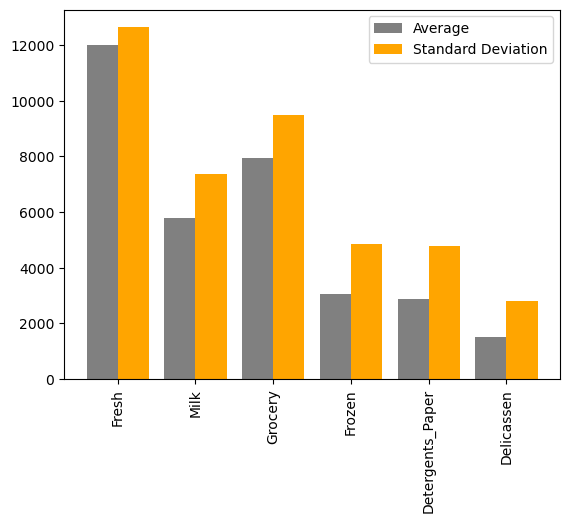

In [7]:
# Get the statistics
averages = wholesale.mean()
st_dev = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

plt.bar(x_ix - 0.2, averages, color = "grey", label = "Average", width = 0.4)
plt.bar(x_ix + 0.2, st_dev, color = "orange", label = "Standard Deviation", width = 0.4)
plt.xticks(x_ix, x_names, rotation = 90)
plt.legend()
plt.show();

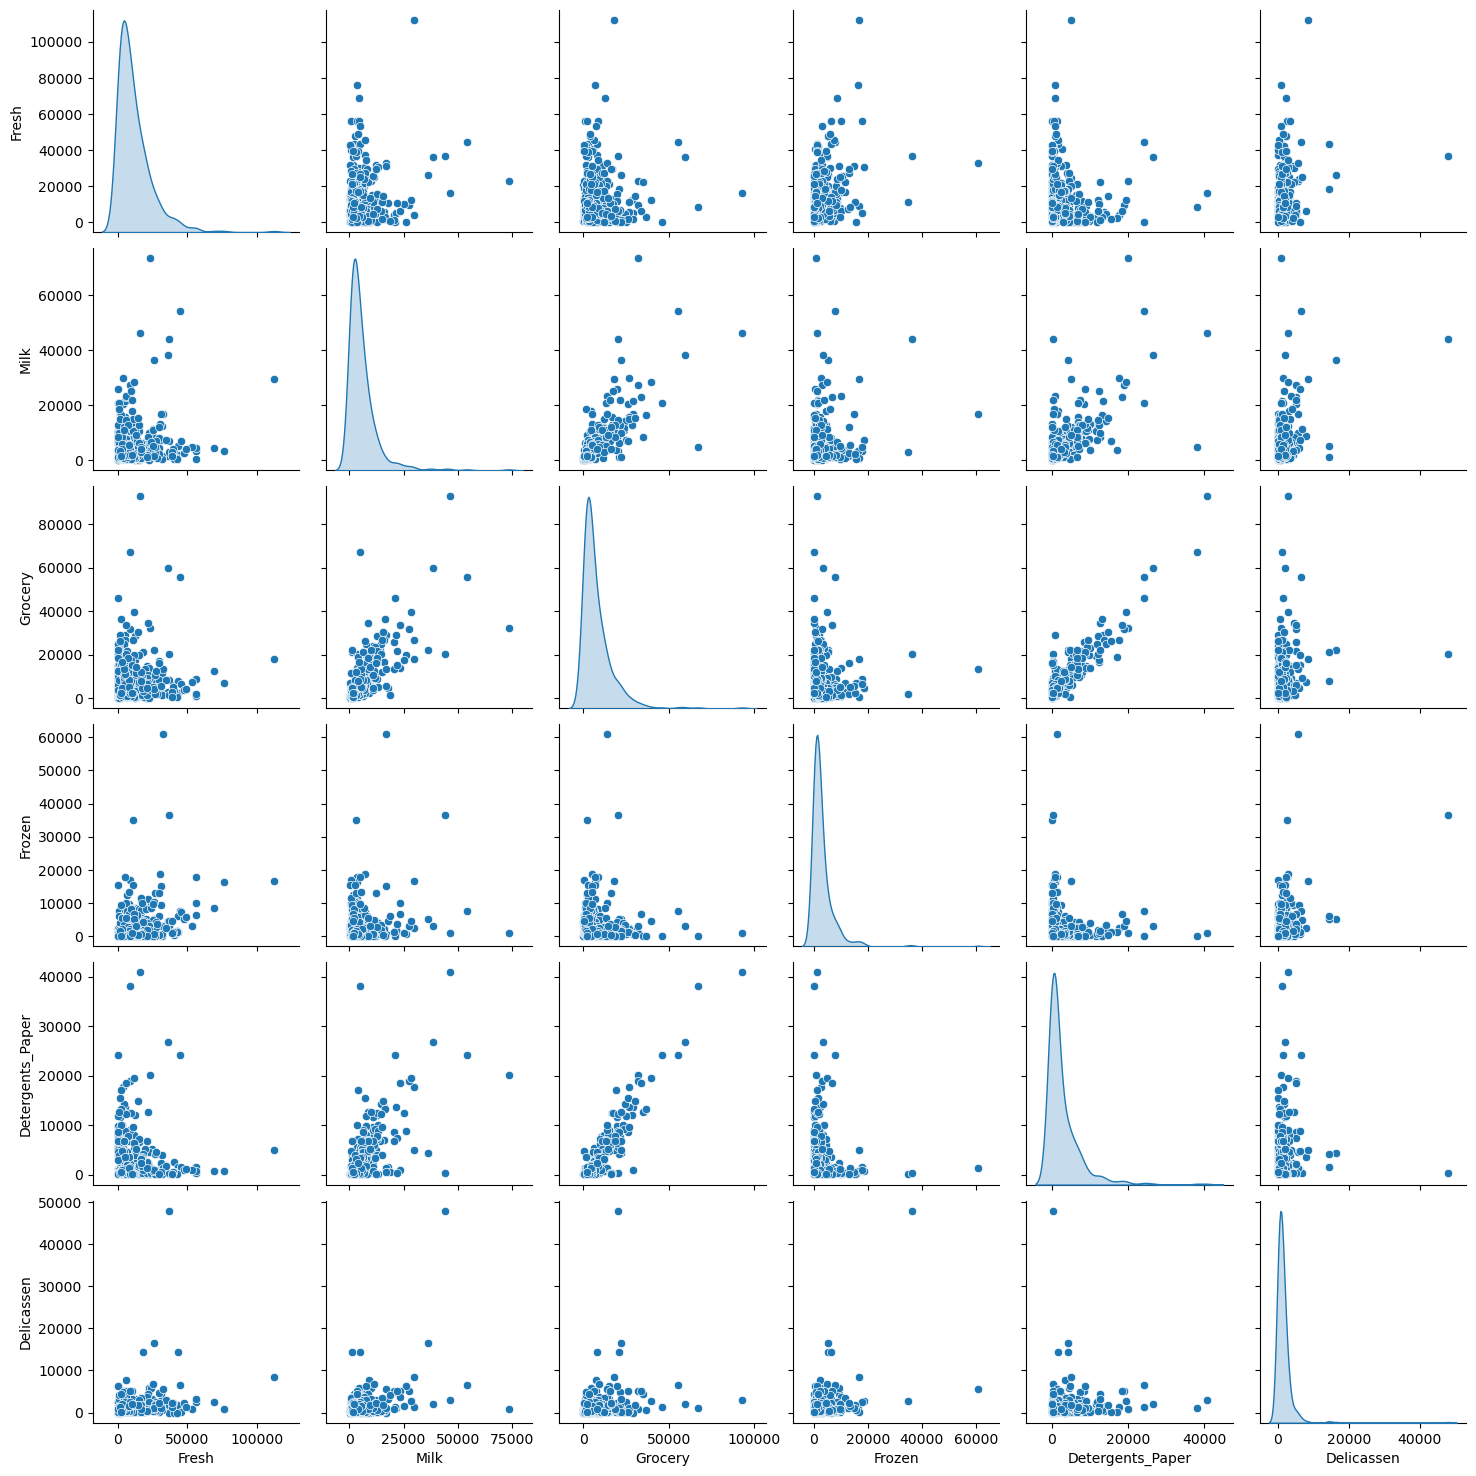

In [8]:
sns.pairplot(wholesale, diag_kind = "kde")
plt.show();

In [9]:
# Not normal distrubition

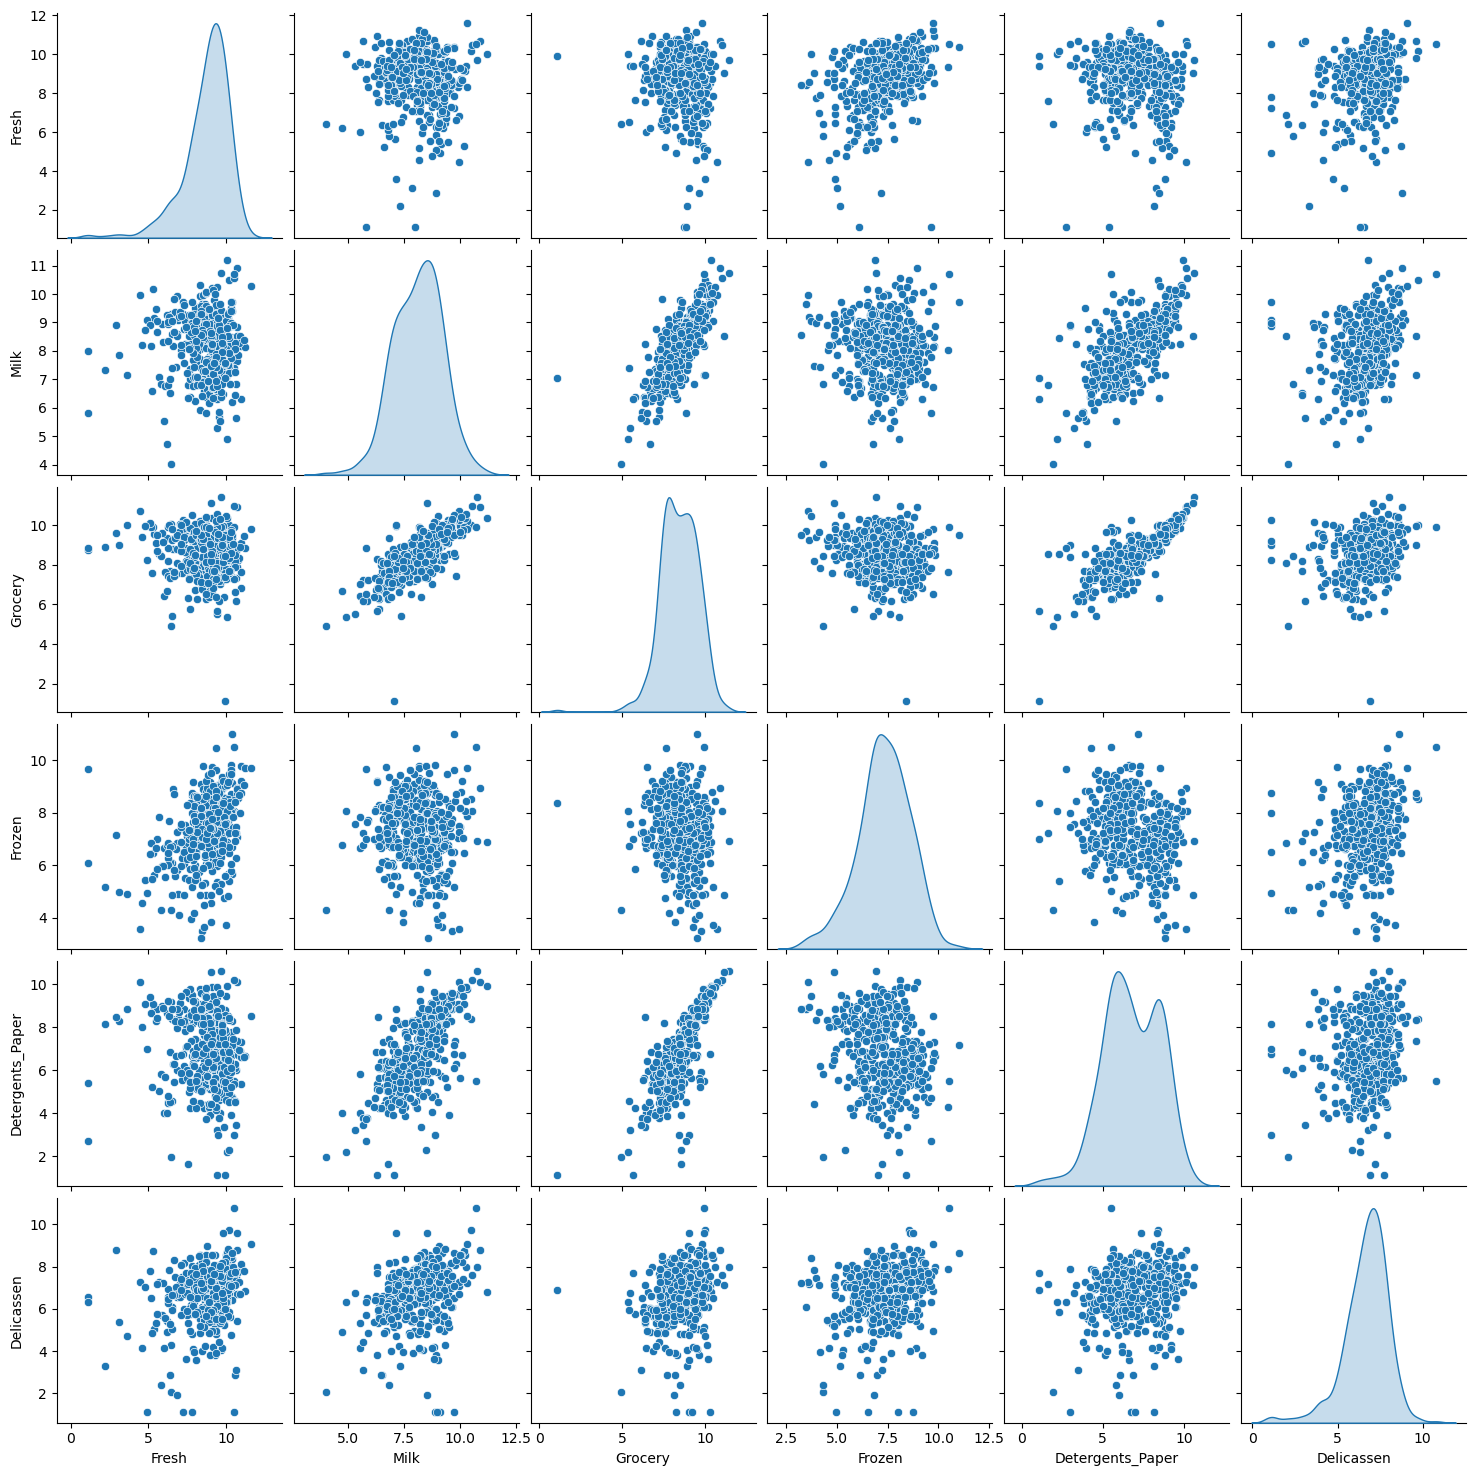

In [10]:
# log transformation
wholesale_log = np.log(wholesale)

sns.pairplot(wholesale_log, diag_kind = "kde")
plt.show();

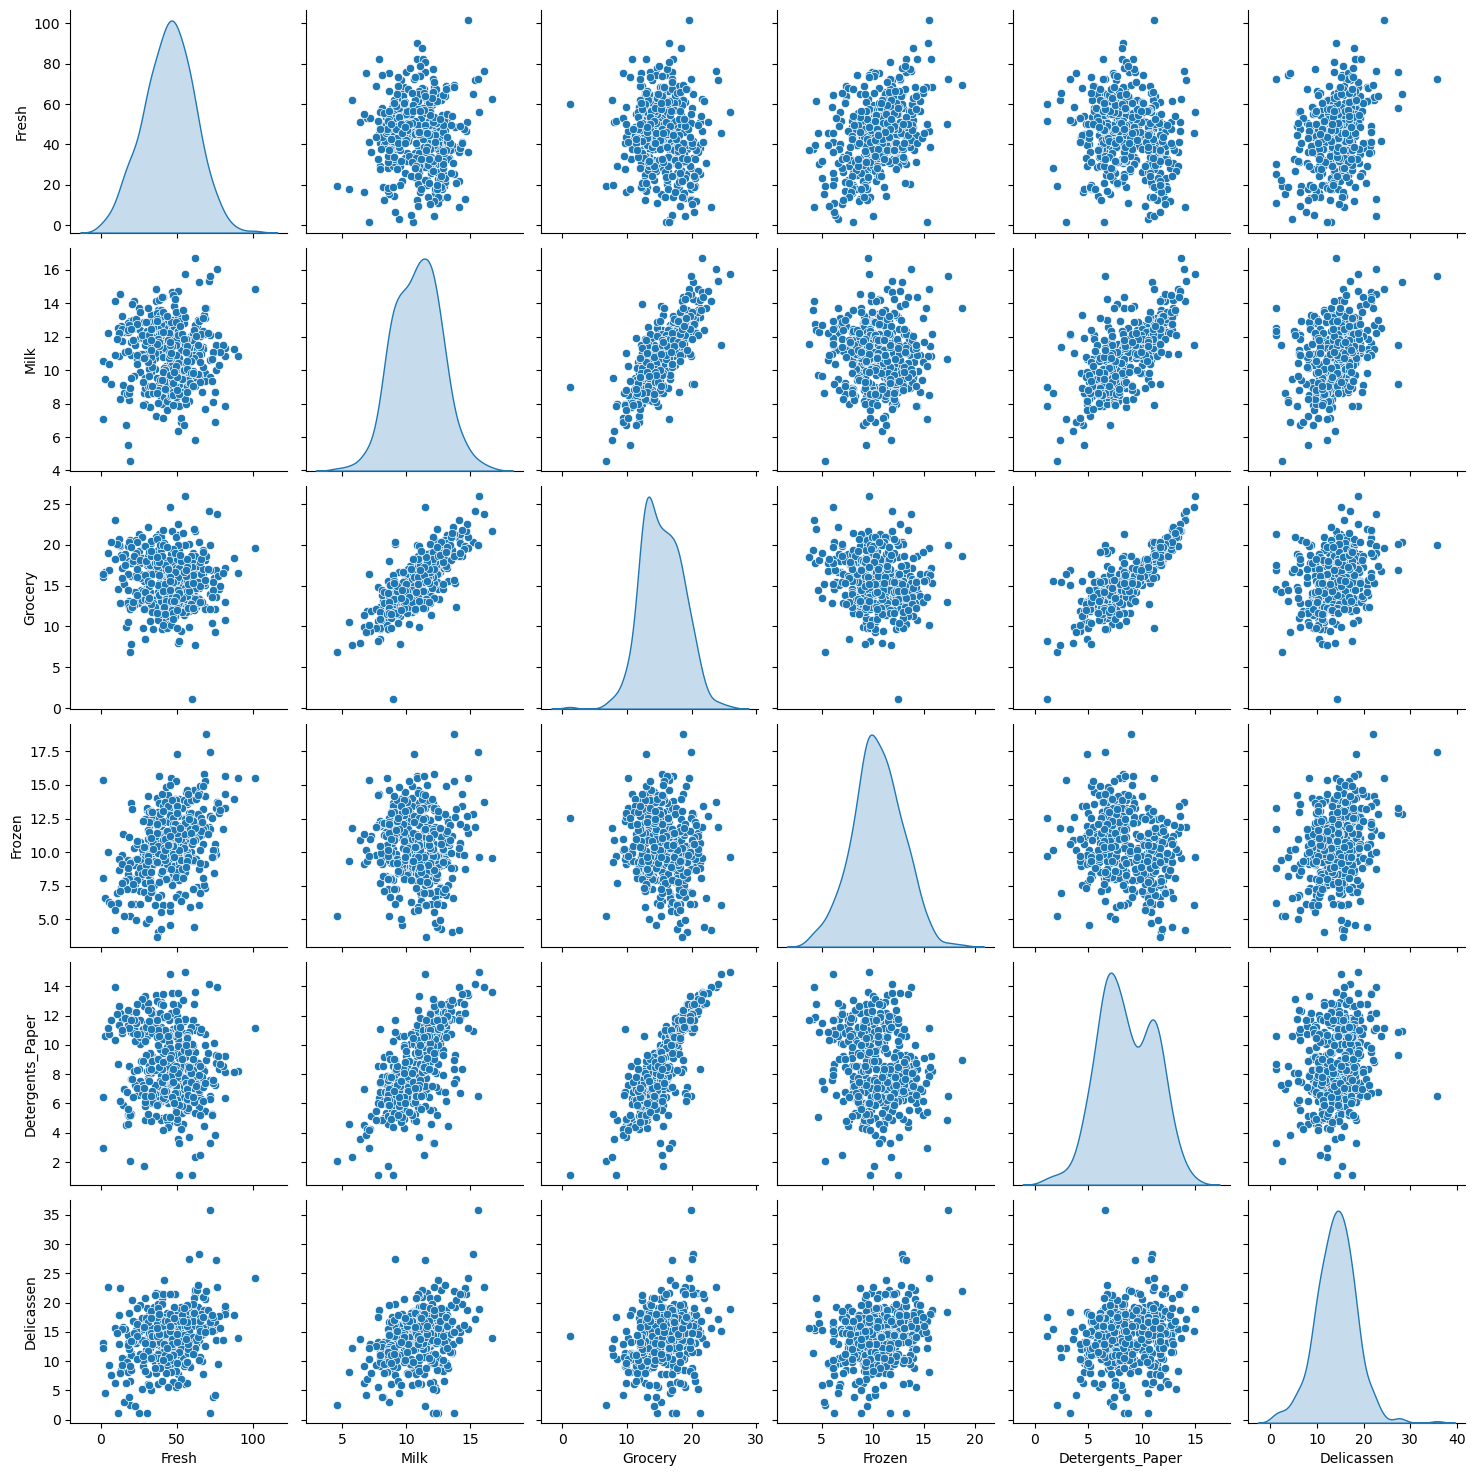

In [11]:
# second option: box-cox transformation
def boxcox_df(x):
    x_boxcox, _ = stats.boxcox(x)
    return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis = 0)
sns.pairplot(wholesale_boxcox, diag_kind = "kde")
plt.show();

In [12]:
# scaling
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(data = wholesale_scaled,
                                index = wholesale_boxcox.index,
                                columns = wholesale_boxcox.columns)

wholesale_scaled_df.agg(["mean", "std"]).round()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


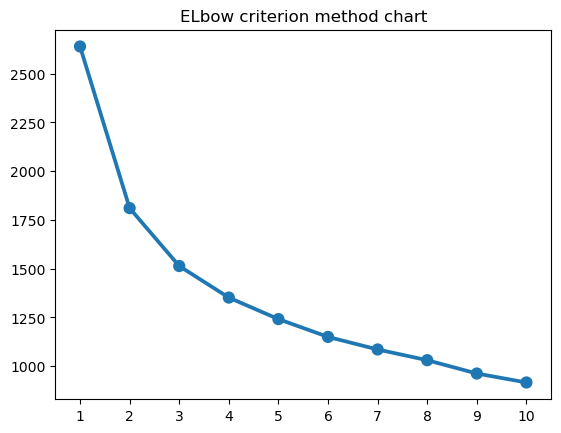

In [13]:
# number of clusters
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters = k, random_state = 333)
    kmeans.fit(wholesale_scaled_df)
    sse[k] = kmeans.inertia_
    
plt.title("ELbow criterion method chart")
sns.pointplot(x = list(sse.keys()), y = list(sse.values()))
plt.show();

In [14]:
# segmentation with K-Means
kmeans = KMeans(n_clusters = 4, random_state = 123)
kmeans.fit(wholesale_scaled_df)
wholesale_kmeans4 = wholesale.assign(segment = kmeans.labels_)

In [15]:
kmeans4_averages = wholesale_kmeans4.groupby(["segment"]).mean().round(0)
kmeans4_averages

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
segment,,,,,,
0,10229.0,12752.0,17996.0,1912.0,7767.0,2338.0
1,9923.0,1832.0,2368.0,2431.0,410.0,651.0
2,3739.0,6346.0,10622.0,689.0,4398.0,575.0
3,24453.0,5026.0,5028.0,7429.0,843.0,3009.0


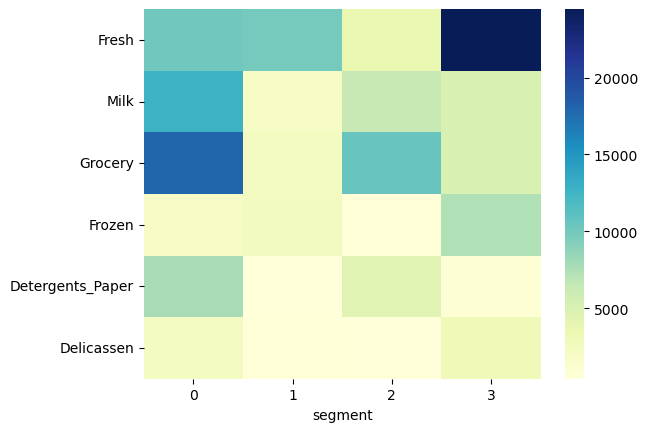

In [16]:
sns.heatmap(kmeans4_averages.T, cmap = "YlGnBu")
plt.show();

It is clear that;

- Segment 0 is a heavy user of fresh, milk, grocery, detergent and paper products
- Segment 1 buys mostly fresh produce but less than segment 3
- Segment 2 mostly buys for groceries
- Segment 3 buys mostly milk and fresh

In [17]:
# segmentation with NMF
nmf = NMF(3)
nmf.fit(wholesale)
components = pd.DataFrame(nmf.components_, columns = wholesale.columns)

segment_weights = pd.DataFrame(nmf.transform(wholesale), columns = components.index)
segment_weights.index = wholesale.index
wholesale_nmf3 = wholesale.assign(segment = segment_weights.idxmax(axis = 1))

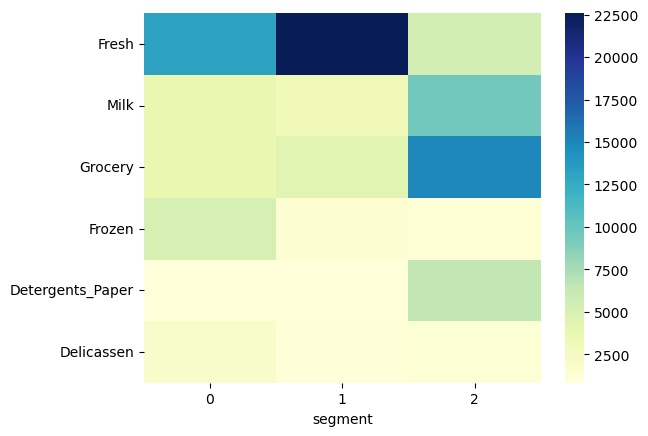

In [18]:
nmf3_averages = wholesale_nmf3.groupby("segment").mean().round(0)
sns.heatmap(nmf3_averages.T, cmap = "YlGnBu")
plt.show();